In [2]:
import numpy as np
import matplotlib.pyplot as plt

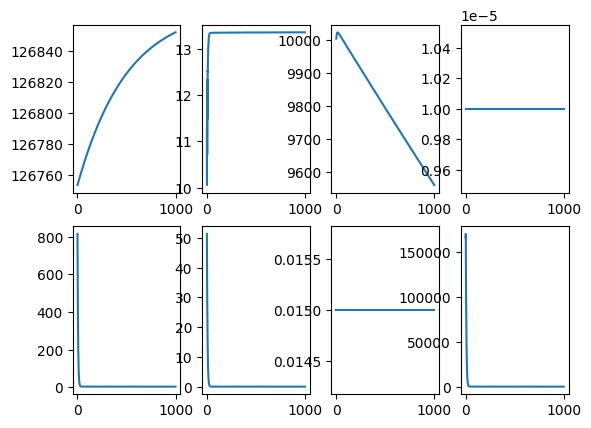

In [43]:
class ODE:
    def __init__(self, data):
        for key, value in data.items():
            setattr(self, key, value)

        if not getattr(self, "state_keys",0):
            self.state_keys = list(data.keys())
        if not getattr(self, "timestep",0):
            self.timestep = 1
        for key in self.state_keys:
            setattr(self, key+"0", data[key])

    def __str__(self):
        return str(self.__dict__)

    def get_state(self):
        """Update state vector to values given by input"""
        x = [getattr(self,key) for key in self.state_keys]
        return x

    def update_state(self, x_new):
        """Update state vector to values given by input"""
        for key, val in zip(self.state_keys, x_new):
            setattr(self, key, val)
        return

    def reset(self):
        """Resets state to x0"""
        x0 = [getattr(self,key+"0") for key in self.state_keys]
        self.update_state(x0)
        return

    def time_arr(self, length):
        return np.arange(0, length*self.timestep, self.timestep)

    def euler_step(self, dx):
        """
        Updates state using state vector derivative and one step of eulers method.
        
        Parameters
        ----------
        dx : numpy array
            Derivative of state vector.
        """
        x_new = self.get_state() + dx * self.timestep
        self.update_state(x_new)
        return


import json


def simulate(self,G_list):
    res = []
    ISR = []
    for G in G_list:
        isr = self.eval(G)
        ISR.append(isr)
        res.append(self.get_state())
    return np.array(res), ISR

pk = PKPM()
res, ISR = simulate(pk, 4.58*np.ones(1000))
fig, ax = plt.subplots(2,4)
for i in range(7):
    ax[i//4, i%4].plot(res[:,i])
ax[1, 3].plot(ISR)

In [29]:
print(res)

[[ 1.27242385e+005  4.50040585e+001  1.00000000e+004  2.78000000e-002
   8.17517500e+002  5.49825000e+001  9.00000000e-002]
 [ 1.27731403e+005 -8.36545124e+001  8.72134960e+003 -5.00400000e-001
   2.05470410e+003  1.81062711e+001  5.82180000e+002]
 [ 1.28220055e+005  4.40997881e+005 -4.10363497e+005  9.53540000e+000
  -7.26623656e+004 -5.25429010e+004 -2.15697300e+004]
 [ 1.28708340e+005 -2.49899429e+014  2.49899447e+014 -1.81144800e+002
  -5.68514030e+009 -5.66777769e+009  6.10068360e+005]
 [ 1.29196259e+005 -4.32042606e+029  4.32042606e+029  3.44177900e+003
  -1.99726187e+017  7.96358124e+015 -1.53953396e+007]
 [ 1.29683811e+005 -2.64846518e+052  2.64846518e+052 -6.53937732e+004
   7.43451554e+033  4.60301649e+029  3.64788811e+008]
 [ 1.30170999e+005  2.22355723e+090 -2.22355723e+090  1.24248172e+006
   9.81701802e+059 -9.90361459e+059 -8.30425664e+009]
 [ 1.30657820e+005 -9.14350715e+159  9.14350715e+159 -2.36071526e+007
  -2.81366149e+116  2.81366149e+116  1.83872992e+011]
 [ 1.311

In [19]:
data = {
    "SRs": 0,
    "alpha": 89.9,
    "gamma": 0.76,
    "KD" : 6.6,
    "h" : 92.5
}
class Pancreas(ODE):
    def __init__(self, model, patient, **kwargs):
        self.timestep = patient.timestep
        self.Gbar = patient.Gbar
        self.model = model.upper()
        with open('config.json', 'r') as f:
            defaults = json.load(f)[self.model]
        defaults.update(kwargs)
        super().__init__(defaults)

    
class PKPM(ODE):
    def __init__(self, **kwargs):
        with open('config.json', 'r') as f:
            defaults = json.load(f)["PK"]
        defaults.update(kwargs)
        super().__init__(defaults)

    def eval(self, G):
        if G <= self.Gu: # if glucose is low
            f = self.fb
            alpha2 = 0
            idx = 0 # use first value for params with two values
        else: # if glucose is high
            idx = 1 # use second value for params with two values
            f = self.fb + (1 - self.fb) *  (G - self.Gu) / (self.Kf +  G - self.Gu)
            if G <= self.Gl: # if glucose is below the upper level
                alpha2 = self.hhat * (G - self.Gu)/(G - self.Gu) 
            else: # if glucose is above the upper level
                alpha2 = self.hhat

        # ode
        dM = self.alpha1[idx] - self.delta1[idx] * self.M
        dP = self.v[idx] * self.M - self.delta2 * self.P - self.k * self.P * self.rho * self.DIR
        dR =  self.k * self.P * self.rho * self.DIR - self.gamma * self.R
        dgamma = self.eta * (-self.gamma + self.gammab + alpha2)
        dD = self.gamma * self.R - self.k1p * (self.CT - self.DIR) * self.D - self.k1m * self.DIR - self.rho * self.DIR
        dDIR = self.k1p * (self.CT - self.DIR) * self.D - self.k1m * self.DIR - self.rho * self.DIR
        drho = self.zeta * (-self.rho + self.rhob + self.krho * (self.gamma - self.gammab))
        
        dx = np.array([dM, dP, dR, dgamma, dD, dDIR, drho])
        ISR = max(self.I0 * self.rho * self.DIR * f * self.N,0) # do not let isr be negative
        x_new = dx * self.timestep + self.get_state()
        self.update_state(x_new)
        return ISR


class SD(ODE):
    def __init__(self,alpha, gamma, h, KD, ybar, timestep):
        data = {
            "state_keys" : ["SRs", "yprev"],
            "SRs" : 0,
            "ybar" : ybar,
            "yprev" : ybar,
            "alpha" : alpha,
            "gamma" : gamma,
            "h" : h,
            "KD" : KD,
            "timestep" : timestep
        }
        super().__init__(data)

    
    def eval(self,y):
        dy = (y - self.yprev)/self.timestep # approx derivative of y
        dSRs = -self.alpha * (self.SRs + self.gamma * (self.h - y))
        SRD = max(dy * self.KD, 0)
        res = max(self.SRs + SRD,0)

        self.SRs += dSRs * self.timestep
        self.yprev = y
        return res


class PID(ODE):
    def __init__(self, Kp, Td, Ti, ybar, timestep):
        data = {
            "state_keys" : ["I", "yprev"],
            "I" : 0,
            "yprev" : ybar,
            "Kp" : Kp,
            "Td" : Td,
            "Ti" : Ti,
            "ybar" : ybar,
            "timestep" : timestep
        }
        super().__init__(data)

    def eval(self,y):
        dy = (y - self.yprev)/self.timestep # approx derivative of y
        ek = y - self.ybar # error

        P = self.Kp * ek
        dI = P/self.Ti
        D = self.Kp * self.Td * dy

        res = max(P + self.I + D, 0)

        self.yprev = y 
        self.I += dI * self.timestep # Updates integral term
        return res        

pan = SD(3,3,3,3,3,3)
pan.eval(4)
print(pan)

{'state_keys': ['SRs', 'yprev'], 'SRs': 27, 'ybar': 3, 'yprev': 4, 'alpha': 3, 'gamma': 3, 'h': 3, 'KD': 3, 'timestep': 3, 'SRs0': 0, 'yprev0': 3}


In [ ]:
p = patient()
p.pancreas.get_insulin()